In [184]:
# import dependencies

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import plotly.express as px
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

### Download data from AWS RDS to DataFrame

In [185]:
# Database engine to connect with AWS RDS

dialect = 'postgresql'
username = 'postgres'
password = 'bootcamp2021'
host = 'bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com'
database = 'crime'
engine = create_engine(f'{dialect}://{username}:{password}@{host}/{database}')

In [186]:
# upload additional tables

property_type_df_file = os.path.join('data_prep', 'property_type_df.csv')
pd.read_csv(property_type_df_file).to_sql(name='property_type_crime', con=engine, if_exists='replace')

violent_type_df_file = os.path.join('data_prep', 'violent_type_df.csv')
pd.read_csv(violent_type_df_file).to_sql(name='violent_type_crime', con=engine, if_exists='replace')

In [187]:
# list all the tables on the AWS RDS

inspector = inspect(engine)
inspector.get_table_names()

['offense_cat_offender_race_2020',
 'offense_cat_offender_sex_2020',
 'offense_cat_type_2020',
 'offense_cat_victim_age_2020',
 'offense_cat_victim_race_2020',
 'offense_cat_victim_sex_2020',
 'state_pop_agencies_2020',
 'gpd_by_state_2020',
 'state_size',
 'property_type_crime',
 'violent_type_crime',
 'offense_cat_loc_2020',
 'offense_cat_state_2020',
 'law_enforcement_state_2020',
 'law_enforcement_state_city_2020',
 'offense_cat_offender_age_2020']

In [188]:
with engine.connect() as conn:
    violent_crime_df = pd.read_sql("SELECT * FROM violent_type_crime", conn)
    property_crime_df = pd.read_sql("SELECT * FROM property_type_crime", conn)

property_crime_df.drop(['index'], axis=1, inplace=True)
property_crime_df.set_index('FIPS', inplace=True)

violent_crime_df.drop('index', axis=1, inplace=True)
violent_crime_df.set_index('FIPS', inplace=True)

print(property_crime_df.shape)
print(violent_crime_df.shape)

(2071, 15)
(2000, 15)


In [532]:
violent_crime_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


In [533]:
property_crime_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
FIPS,,,,,,,,,,,,,,,
1001.0,384.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1003.0,737.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
1007.0,69.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
1015.0,211.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
1033.0,267.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


### Analyse violent crimes

#### examine the dataset

In [535]:
# change index to default

original_df = violent_crime_df.copy()
original_df.reset_index(drop=True, inplace=True)
original_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.0,71,35,36,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4
1996,23.0,95,39,56,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2
1997,2.0,47,34,13,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8
1998,4.0,9,8,1,10.241615,29.751171,36.620987,23.386225,4.1,55122.0,8129,1.402002,11.1,13.9,12.3


In [538]:
print(original_df['crimes'].value_counts())
print(original_df['civilians'].value_counts())

0.0       130
1.0       109
2.0        86
3.0        76
4.0        74
         ... 
163.0       1
1484.0      1
881.0       1
5957.0      1
154.0       1
Name: crimes, Length: 299, dtype: int64
1       108
2       103
3        83
0        80
5        75
       ... 
2078      1
188       1
323       1
292       1
173       1
Name: civilians, Length: 248, dtype: int64


In [539]:
# filter crimes=0
zero_df = original_df[(df['crimes']==0) | (original_df['civilians']==0)]
zero_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
186,0.0,7,3,4,12.628337,28.131416,39.219711,20.020535,1.7,53577.0,1296,0.310083,12.6,18.5,18.3
198,0.0,4,4,0,11.500000,33.107143,31.571428,23.821428,1.5,53432.0,4318,2.423494,10.4,14.8,14.2
201,0.0,28,11,17,8.117731,31.521481,37.621647,22.739141,3.6,65960.0,6465,0.774968,10.3,12.8,11.3
204,0.0,18,8,10,16.939325,30.544626,30.420378,22.095673,4.1,37004.0,6468,0.788151,25.4,38.8,34.3
205,0.0,3,3,0,6.185567,25.773195,32.371136,35.670105,2.1,50524.0,544,0.542016,13.7,19.3,20.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,3.0,20,20,0,5.466028,33.667248,40.853657,20.013065,6.2,48813.0,5715,2.910324,12.7,20.8,17.2
1959,0.0,11,9,2,8.095781,42.569366,31.394907,17.939947,5.9,40300.0,4579,4.943763,25.3,44.0,44.7
1966,1.0,26,26,0,9.857666,40.829605,30.280602,19.032127,3.0,51295.0,17539,11.553103,12.5,18.5,16.4
1974,0.0,74,36,38,6.281127,29.981836,34.657528,29.079510,4.3,55576.0,21593,9.720213,11.2,19.0,18.9


In [540]:
# remove rows of 0 crimes and 0 civilians

clean_df = original_df[(original_df['crimes']>0) & (original_df['civilians']>0)]
clean_df.reset_index(drop=True, inplace=True)
clean_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,6.0,57,20,37,4.672548,25.635998,38.734070,30.957382,4.0,64030.0,30012,4.592168,8.5,10.0,8.6
1805,10.0,71,35,36,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4
1806,23.0,95,39,56,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2
1807,2.0,47,34,13,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8


#### normalize a few columns against population

In [541]:
# normalize columns against population

norm_df = clean_df.copy()

columns_to_normalize = [
    'crimes',
    'total_law_emp',
    'officers',
    'civilians'    
]

for col in columns_to_normalize:
    norm_df[col] = clean_df[col] / clean_df['population']

norm_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,0.000996,0.001250,0.000562,0.000688,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,0.000783,0.001422,0.000533,0.000889,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,0.000133,0.000444,0.000400,0.000044,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,0.000156,0.000487,0.000443,0.000043,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,0.001064,0.000973,0.000624,0.000349,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


### Check skewness

In [542]:
norm_df.skew()

crimes                                2.991272
total_law_emp                         3.240630
officers                              3.404885
civilians                             4.158764
percent_edu_less_than_high_school     1.067508
percent_edu_high_school              -0.403074
percent_edu_some_college             -0.008065
percent_edu_bachelor_or_higher        1.367854
unemployment_rate                     2.168104
median_HH_Income                      1.505033
population                           12.975657
pop_dens_ppl_per_sqkm                 7.709310
percent_poverty_all_age               0.933746
percent_poverty_age_0-17              0.639058
percent_poverty_age_5-17              0.695144
dtype: float64

In [543]:
skewed_columns = ['crimes',
                  'total_law_emp',
                  'officers',
                  'civilians',
                  'population',
                  'pop_dens_ppl_per_sqkm']

In [553]:
# scaled_df = norm_df.copy()

# from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

# Create scaler instance

df_scaler = QuantileTransformer(random_state=0, output_distribution='normal')
# df_scaler = StandardScaler(with_mean=False) # keep positive
# df_scaler = StandardScaler() 
# df_scaler = PowerTransformer(method="yeo-johnson")

# Fit the scaler
df_scaler.fit(norm_df)
# y_scaler.fit(np.asarray(y).reshape(-1, 1))

# Scale the data
scaled_df = df_scaler.transform(norm_df)
scaled_df = pd.DataFrame(scaled_df, columns=norm_df.columns, index=norm_df.index)
# scaled_y = y_scaler.transform(np.asarray(y).reshape(-1, 1))
# scaled_y = pd.DataFrame(scaled_y, columns=['crimes'], index=X.index)

scaled_df.head()

scaled_df.skew()

crimes                               0.009987
total_law_emp                       -0.049568
officers                            -0.005842
civilians                           -0.003140
percent_edu_less_than_high_school   -0.004471
percent_edu_high_school              0.000657
percent_edu_some_college             0.000349
percent_edu_bachelor_or_higher       0.000273
unemployment_rate                    0.002214
median_HH_Income                     0.000099
population                          -0.000681
pop_dens_ppl_per_sqkm               -0.000706
percent_poverty_all_age             -0.000568
percent_poverty_age_0-17             0.000121
percent_poverty_age_5-17             0.003576
dtype: float64

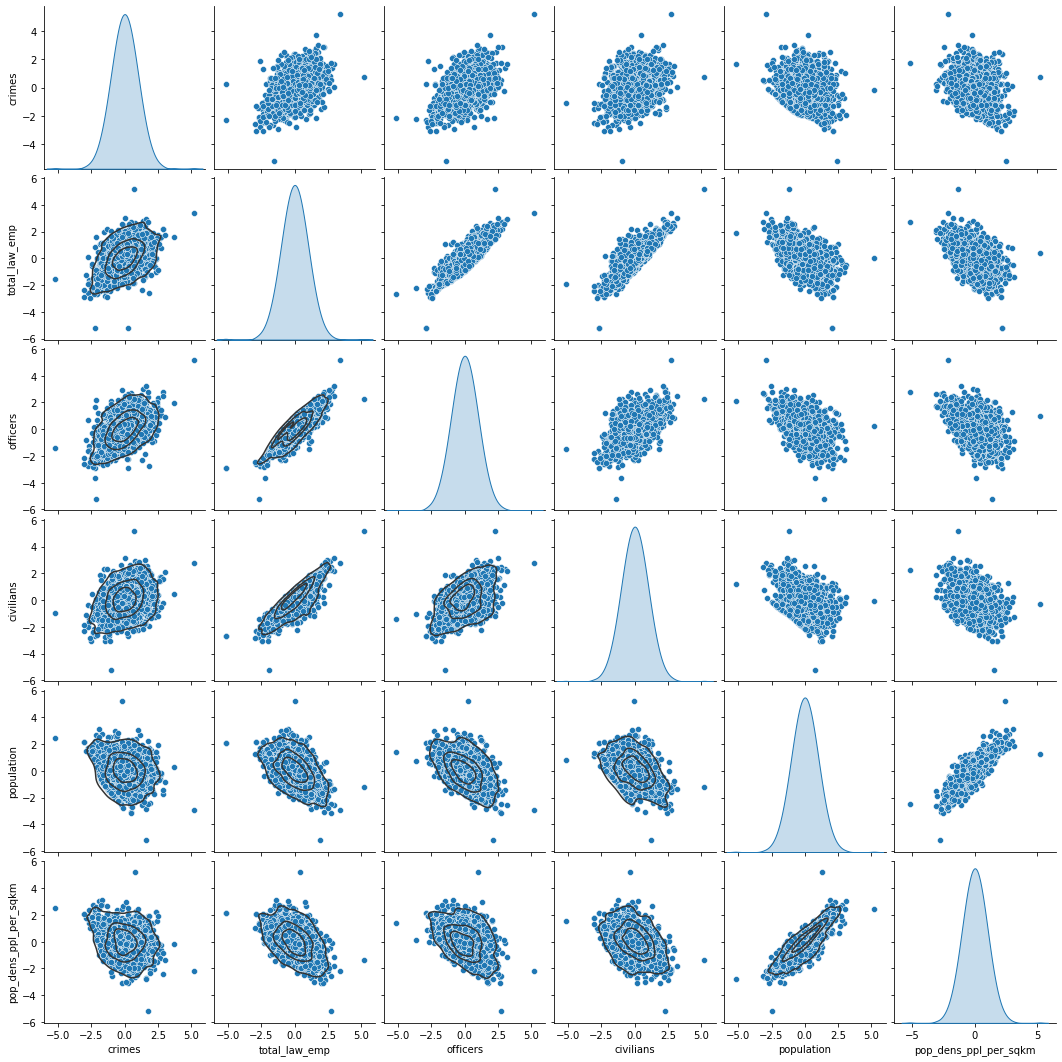

In [554]:
sns.pairplot(scaled_df[skewed_columns], 
             diag_kind='kde').map_lower(sns.kdeplot, levels=4, color='.2')

Select QuantileTransformer as the scaler

### Create input and target 

In [555]:
y = scaled_df['crimes']
X = scaled_df.drop('crimes', axis=1)

In [556]:
print(y.skew())
print(X.skew())

0.009987423257466477
total_law_emp                       -0.049568
officers                            -0.005842
civilians                           -0.003140
percent_edu_less_than_high_school   -0.004471
percent_edu_high_school              0.000657
percent_edu_some_college             0.000349
percent_edu_bachelor_or_higher       0.000273
unemployment_rate                    0.002214
median_HH_Income                     0.000099
population                          -0.000681
pop_dens_ppl_per_sqkm               -0.000706
percent_poverty_all_age             -0.000568
percent_poverty_age_0-17             0.000121
percent_poverty_age_5-17             0.003576
dtype: float64


### Build pipeline to preprocess the data

In [557]:
from sklearn import set_config

set_config(display="diagram")

In [558]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(df)

[]

In [559]:
num_selector(X)

['total_law_emp',
 'officers',
 'civilians',
 'percent_edu_less_than_high_school',
 'percent_edu_high_school',
 'percent_edu_some_college',
 'percent_edu_bachelor_or_higher',
 'unemployment_rate',
 'median_HH_Income',
 'population',
 'pop_dens_ppl_per_sqkm',
 'percent_poverty_all_age',
 'percent_poverty_age_0-17',
 'percent_poverty_age_5-17']

In [560]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE7C8>)])

In [563]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
#     PowerTransformer(method="yeo-johnson"), SimpleImputer(strategy="mean", add_indicator=True)
#     QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal'), 
#     SimpleImputer(strategy="mean", add_indicator=True)
#     StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
#     StandardScaler(with_mean=False), SimpleImputer(strategy="mean", add_indicator=True)
    SimpleImputer(strategy="mean", add_indicator=True) # no need for scaler since already scaled
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE7C8>)])

In [564]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE7C8>)])),
                ('lassocv', LassoCV())])

In [565]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE7C8>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [566]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE7C8>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [567]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.com...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE808>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001C6513FE7C8>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

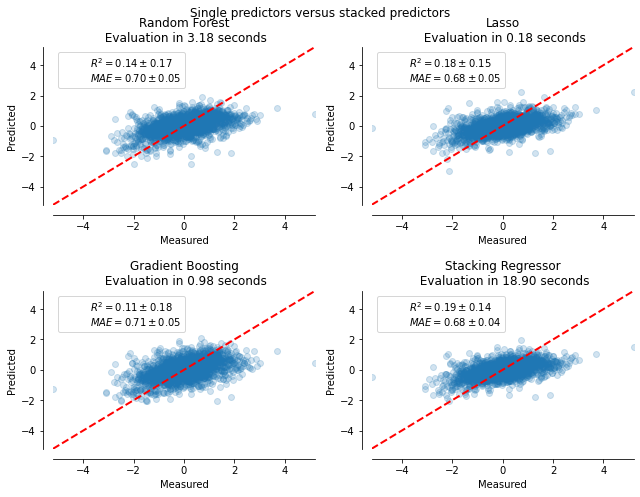

In [568]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### None of the above linear or tree models achieved acceptable accuracy.
### Try unsupervised machine learning to identify clusters and improve accuracy

In [569]:
# Create scaler instance

'''
X_scaler = QuantileTransformer(random_state=0, output_distribution='normal')
y_scaler = QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal')
# X_scaler = StandardScaler(with_mean=False) # keep positive
# y_scaler = StandardScaler(with_mean=False) # keep positive

# Fit the scaler
X_scaler.fit(X)
y_scaler.fit(np.asarray(y).reshape(-1, 1))

# Scale the data
scaled_X = X_scaler.transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)
scaled_y = y_scaler.transform(np.asarray(y).reshape(-1, 1))
scaled_y = pd.DataFrame(scaled_y, columns=['crimes'], index=X.index)'''

scaled_X.head()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,0.478025,0.312376,0.700711,0.019411,-0.143354,-0.496431,0.672605,-0.186756,0.311905,0.518487,0.538504,-0.230353,-0.320290,-0.369558
1,1.398344,1.164444,1.616663,-0.436311,-0.910997,0.076898,1.049059,-0.021329,0.457572,1.226411,0.734767,-0.699108,-0.647177,-0.507774
2,-1.218002,-0.798769,-1.501861,1.287629,1.666669,-1.438188,-1.817714,0.198258,-0.565480,-0.150761,-0.142446,1.149742,0.853480,0.924252
3,0.336178,0.691121,-0.699108,0.638474,-0.241635,0.425339,-0.222256,0.605955,-0.587389,0.930911,0.934344,0.715218,0.721714,0.673702
4,0.288750,0.387078,0.166367,0.524126,0.491979,-0.341498,-0.275276,0.790168,-0.699945,0.505781,0.532504,0.269184,0.144780,0.199538


In [313]:
scaled_y.skew()

crimes   -1.804914
dtype: float64

In [570]:
scaled_X.skew()

total_law_emp                       -0.048201
officers                            -0.186528
civilians                           -1.719721
percent_edu_less_than_high_school   -0.004042
percent_edu_high_school             -0.002388
percent_edu_some_college            -0.000670
percent_edu_bachelor_or_higher       0.003455
unemployment_rate                   -0.053179
median_HH_Income                    -0.000978
population                           0.000230
pop_dens_ppl_per_sqkm                0.001508
percent_poverty_all_age              0.003448
percent_poverty_age_0-17            -0.000941
percent_poverty_age_5-17             0.000212
dtype: float64

In [315]:
log_y = pd.DataFrame(np.sqrt(y))
log_y.skew()

crimes    4.439679
dtype: float64

In [316]:
print(scaled_y.skew())
print(scaled_X.skew())

crimes   -1.804914
dtype: float64
total_law_emp                       -0.048201
officers                            -0.186528
civilians                           -1.719721
percent_edu_less_than_high_school   -0.004042
percent_edu_high_school             -0.002388
percent_edu_some_college            -0.000670
percent_edu_bachelor_or_higher       0.003455
unemployment_rate                   -0.053179
median_HH_Income                    -0.000978
population                           0.000230
pop_dens_ppl_per_sqkm                0.001508
percent_poverty_all_age              0.003448
percent_poverty_age_0-17            -0.000941
percent_poverty_age_5-17             0.000212
dtype: float64


In [317]:
scaled_y

,crimes
0,0.707140
1,1.326092
2,-0.910873
3,0.003764
4,0.739737
...,...
1995,-0.328223
1996,0.144780
1997,-1.077446
1998,-0.776528


In [318]:
scaled_df = scaled_X.merge(scaled_y, how='inner', left_index=True, right_index=True)
scaled_df.head()
scaled_df

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes
0,0.478025,0.312376,0.700711,0.019411,-0.143354,-0.496431,0.672605,-0.186756,0.311905,0.518487,0.538504,-0.230353,-0.320290,-0.369558,0.707140
1,1.398344,1.164444,1.616663,-0.436311,-0.910997,0.076898,1.049059,-0.021329,0.457572,1.226411,0.734767,-0.699108,-0.647177,-0.507774,1.326092
2,-1.218002,-0.798769,-1.501861,1.287629,1.666669,-1.438188,-1.817714,0.198258,-0.565480,-0.150761,-0.142446,1.149742,0.853480,0.924252,-0.910873
3,0.336178,0.691121,-0.699108,0.638474,-0.241635,0.425339,-0.222256,0.605955,-0.587389,0.930911,0.934344,0.715218,0.721714,0.673702,0.003764
4,0.288750,0.387078,0.166367,0.524126,0.491979,-0.341498,-0.275276,0.790168,-0.699945,0.505781,0.532504,0.269184,0.144780,0.199538,0.739737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.509202,0.419741,0.661162,-2.309898,0.005018,1.455542,0.333987,0.267884,1.418295,-0.825992,-1.786227,-1.505747,-1.606755,-1.634747,-0.328223
1996,0.721714,0.494971,0.949547,-0.985630,-0.204692,1.220969,0.298532,0.329548,1.531371,0.365319,-1.337408,-1.228607,-1.223287,-1.418119,0.144780
1997,0.180377,0.387078,-0.119468,-0.972702,1.083409,0.797670,-0.624291,0.329548,1.140670,-0.223916,-0.937959,-1.184447,-1.310017,-1.513589,-1.077446
1998,-1.331018,-0.928105,-1.501861,-0.195851,-0.655676,1.098036,0.408924,-0.100535,0.079981,-0.999404,-1.439131,-0.465405,-0.570161,-0.650274,-0.776528


In [319]:
inertia = []
k = list(range(1, 11))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scaled_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [356]:
n_cluster = 3

In [357]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_.astype(str)

    return data

In [358]:
clusters_df = get_clusters(n_cluster, scaled_df)
clusters_df.head()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes,class
0,0.478025,0.312376,0.700711,0.019411,-0.143354,-0.496431,0.672605,-0.186756,0.311905,0.518487,0.538504,-0.230353,-0.320290,-0.369558,0.707140,2
1,1.398344,1.164444,1.616663,-0.436311,-0.910997,0.076898,1.049059,-0.021329,0.457572,1.226411,0.734767,-0.699108,-0.647177,-0.507774,1.326092,2
2,-1.218002,-0.798769,-1.501861,1.287629,1.666669,-1.438188,-1.817714,0.198258,-0.565480,-0.150761,-0.142446,1.149742,0.853480,0.924252,-0.910873,1
3,0.336178,0.691121,-0.699108,0.638474,-0.241635,0.425339,-0.222256,0.605955,-0.587389,0.930911,0.934344,0.715218,0.721714,0.673702,0.003764,1
4,0.288750,0.387078,0.166367,0.524126,0.491979,-0.341498,-0.275276,0.790168,-0.699945,0.505781,0.532504,0.269184,0.144780,0.199538,0.739737,1


In [359]:
clusters_df.groupby(by='class').count()

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,crimes
class,,,,,,,,,,,,,,,
0,554,554,554,554,554,554,554,554,554,554,554,554,554,554,554
1,791,791,791,791,791,791,791,791,791,791,791,791,791,791,791
2,655,655,655,655,655,655,655,655,655,655,655,655,655,655,655


In [360]:
# Plotting the clusters with three features
fig = px.scatter_3d(clusters_df, 
                    x="total_law_emp", 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y="median_HH_Income", 
                    z="crimes", 
                    color="class", 
                    symbol="class", 
#                     size="crime_to_pop_ratio",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

Cluster 1 appears to be an outlier

In [409]:
n_cluster = 3

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



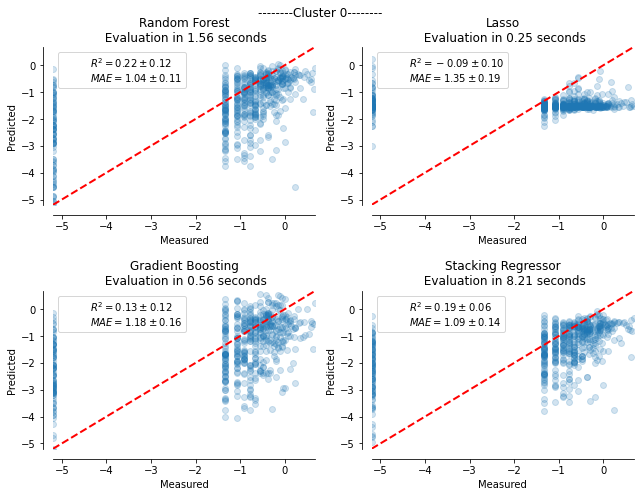

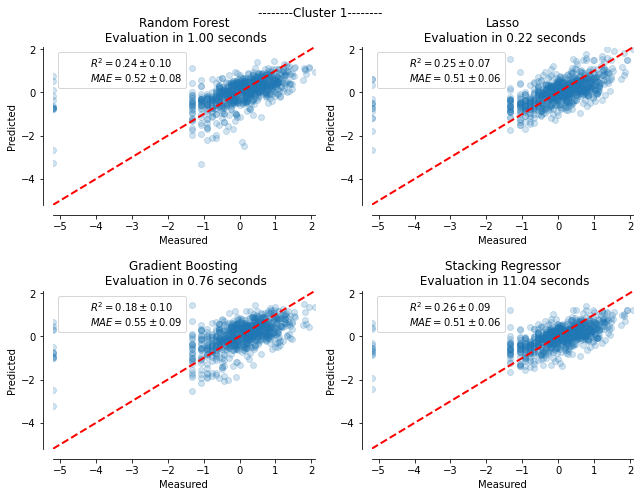

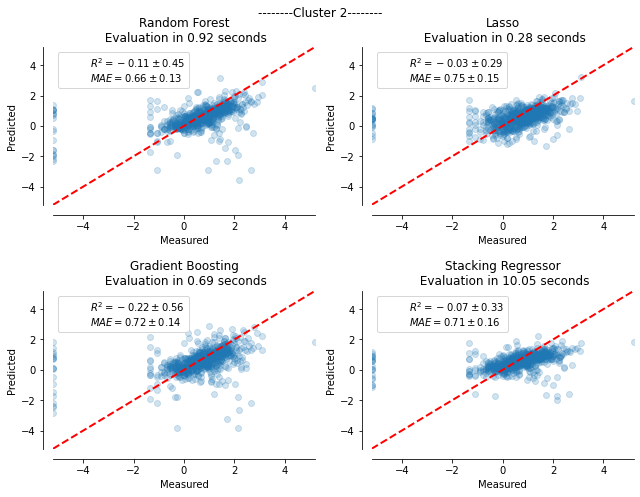

In [410]:
for i in range(n_cluster):

    cluster_no = i

    cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        y = cluster_subset_df['crimes']
        X = cluster_subset_df.drop('crimes', axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        axs = np.ravel(axs)

        for ax, (name, est) in zip(
            axs, estimators + [("Stacking Regressor", stacking_regressor)]
        ):
            start_time = time.time()
            score = cross_validate(
                est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
            )
            elapsed_time = time.time() - start_time

            y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

            plot_regression_results(
                ax,
                y,
                y_pred,
                name,
                (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                    np.mean(score["test_r2"]),
                    np.std(score["test_r2"]),
                    -np.mean(score["test_neg_mean_absolute_error"]),
                    np.std(score["test_neg_mean_absolute_error"]),
                ),
                elapsed_time,
            )

        plt.suptitle(f"--------Cluster {i}--------")
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

### Examine the distribution of "Crimes" data

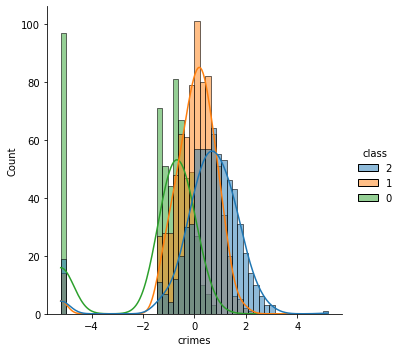

In [411]:
sns.displot(clusters_df.reset_index(), 
            x="crimes",
#             kind='kde',
#             cut=0,
            hue='class',
#             log_scale=True,
            kde=True
            )

### Try NN model

In [412]:
cluster_no = 1

In [413]:
cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
cluster_subset_df.drop('class', axis=1, inplace=True)


nn_y = cluster_subset_df['crimes']
nn_X = cluster_subset_df.drop('crimes', axis=1)

X_train, X_test, y_train, y_test = train_test_split(nn_X, nn_y)

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 6)                 90        
                                                                 
 dense_21 (Dense)            (None, 1)                 7         
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
None
0.3739827010197442


Text(0, 0.5, 'Predicted')

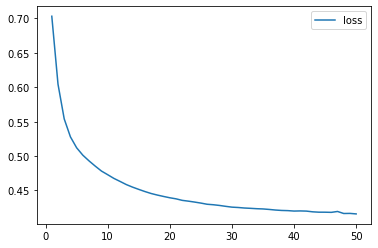

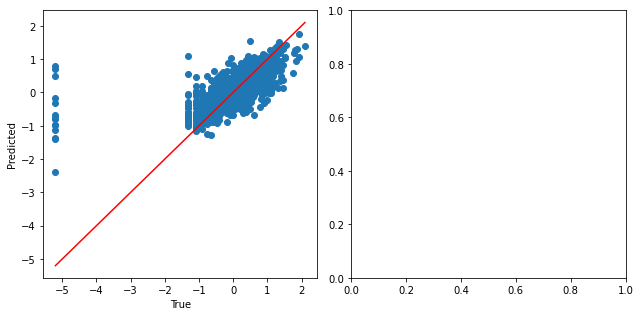

In [414]:
units_input = 6
units_h1 = 0
units_h2 = 0
units_h3 = 0
activation_input = 'relu'
activation_h1 = 'relu'
activation_h2 = 'tanh'
activation_h3 = 'LeakyReLU'
activation_output = 'linear'
epochs = 50


# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=units_input, activation=activation_input, input_dim=nn_X.shape[1]))
if units_h1 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h1, activation=activation_h1))
if units_h2 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h2, activation=activation_h2))
if units_h3 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h3, activation=activation_h3))
nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_output))

# Check the structure of the Sequential model
print(nn_model.summary())

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mean_absolute_error", 
                 optimizer=tf.optimizers.Adam(learning_rate=0.001), 
#                  metrics=["r_square"]
                )

# Fit the model to the training data
fit_model = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

# compare results
result = pd.DataFrame()
result['True'] = nn_y
result['Predicted'] = nn_model.predict(nn_X)

print(r2_score(result['True'],result['Predicted']))

# compare Predicted with True
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
ax1.scatter(result['True'],result['Predicted'])
ax1.plot([min(result['True']), max(result['True'])], [min(result['True']), max(result['True'])], 'r')
ax1.set_xlabel('True')
ax1.set_ylabel('Predicted')
# ax2.scatter(result['True'], result['Predicted'])
# ax2.plot([0, 0.2], [0, 0.2], 'r')
# ax2.set_xlim(0, 0.25)
# ax2.set_ylim(0, 0.25)
# ax2.set_xlabel('True')
# ax2.set_title('Zoom into Diagnol')

In [415]:
r2_score(result['True'],result['Predicted'])

0.3739827010197442

### dimentionality reduction

In [416]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

In [417]:
scaled_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,0.366495,-0.319965,-0.658533,0.172025,-0.001690,-0.120187,-0.509360,0.627668,-0.170232,0.0,0.448041,0.498181,-0.233676,-0.314406,-0.366174
1,0.071454,-0.111642,-0.731893,0.515516,-0.475487,-0.922615,0.069672,1.081967,-0.015202,0.0,1.269958,0.709200,-0.692606,-0.667743,-0.533064
2,-1.152124,-1.512764,-1.103650,-1.381182,1.331539,1.641754,-1.430412,-1.689470,0.202221,0.0,-0.166280,-0.112383,1.161733,0.879880,0.958204
3,-1.098261,-1.439462,-0.978178,-1.384104,0.664688,-0.233323,0.436269,-0.276370,0.590686,0.0,0.915448,0.930166,0.702105,0.743282,0.701208
4,0.451739,-0.687390,-0.502310,-0.549225,0.559203,0.507824,-0.346698,-0.321529,0.765289,0.0,0.439582,0.491939,0.259220,0.146220,0.206119


In [418]:
sum_explained_variance_ratio = []

for i in range(scaled_df.shape[1]):
    # Initialize PCA model
    pca = PCA(n_components=i)

    # Get i principal components 
    df_pca = pca.fit_transform(scaled_df)

    pca_df = pd.DataFrame(
        data=df_pca, #columns=['pc1','pc2','pc3','pc4']
    )

    sum_explained_variance_ratio.append(sum(pca.explained_variance_ratio_))

In [419]:
sum_explained_variance_ratio

[0,
 0.37559134598219196,
 0.6075588170477508,
 0.7120738095805003,
 0.7836924259531447,
 0.8387090647634953,
 0.8882956253762179,
 0.9263195839311065,
 0.9597350729918754,
 0.9834350720454633,
 0.9903819376270127,
 0.9957060633553204,
 0.9987559444904028,
 0.9995331293679571,
 0.9999999999999996]

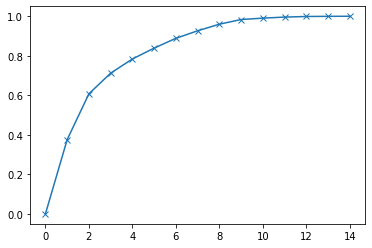

In [420]:
plt.plot(range(scaled_df.shape[1]), sum_explained_variance_ratio, marker='x')

In [421]:
df_pca

array([[ 8.89317485e-01, -5.41832329e-01,  5.56433662e-01, ...,
        -2.33622480e-01,  1.09017909e-02,  3.15052539e-02],
       [ 2.03479665e+00, -3.16128876e-01,  1.16444027e+00, ...,
         3.22345089e-03,  7.13385379e-02, -7.80248956e-02],
       [-2.09458421e+00, -3.00585999e+00, -2.01761578e+00, ...,
         2.44941203e-01, -2.36675296e-02, -7.37923030e-02],
       ...,
       [ 9.36023075e-01,  1.96943840e+00, -1.44493627e+00, ...,
         6.70157540e-02, -7.19458858e-02,  1.01840680e-01],
       [ 8.72122200e-01,  9.70670447e-01, -1.71979036e+00, ...,
        -1.57110029e-01, -5.15066951e-02,  5.78338870e-02],
       [ 8.56755182e-01,  1.08737610e+00, -2.58123477e+00, ...,
         1.41443872e-01,  2.26577646e-04,  1.07577655e-01]])

Number of PCs is selected to be 6

In [422]:
pca = PCA(n_components=6)

# Get i principal components 
df_pca = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(
    data=df_pca, #columns=['pc1','pc2','pc3','pc4']
)

In [423]:
pca_df.head()

,0,1,2,3,4,5
0,0.889317,-0.541832,0.556434,-0.438500,0.010055,-0.173330
1,2.034797,-0.316129,1.164440,0.285847,0.172615,-0.627204
2,-2.094584,-3.005860,-2.017616,-1.135667,0.141519,-0.021821
3,-0.019923,-2.812523,-0.558402,1.127480,0.210065,-0.022229
4,-0.479538,-1.482801,0.198966,-0.145364,-0.773958,0.018105


In [424]:
# Find the best value for K
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [425]:
# Initialize the K-means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add the predicted class columns
pca_df["class"] = model.labels_
pca_df.head()

,0,1,2,3,4,5,class
0,0.889317,-0.541832,0.556434,-0.438500,0.010055,-0.173330,2
1,2.034797,-0.316129,1.164440,0.285847,0.172615,-0.627204,1
2,-2.094584,-3.005860,-2.017616,-1.135667,0.141519,-0.021821,2
3,-0.019923,-2.812523,-0.558402,1.127480,0.210065,-0.022229,2
4,-0.479538,-1.482801,0.198966,-0.145364,-0.773958,0.018105,2


In [426]:
pca_df.hvplot.scatter(
    x="0",
    y="1",
    hover_cols=["class"],
    by="class",
)

:NdOverlay   [class]
   :Scatter   [0]   (1,class)

In [427]:
# Plotting the clusters with three features
fig = px.scatter_3d(pca_df, 
                    x=0, 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y=1, 
                    z=2, 
                    color="class", 
                    symbol="class",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

In [428]:
pca_df.groupby(by='class').count()

,0,1,2,3,4,5
class,,,,,,
0,442,442,442,442,442,442
1,431,431,431,431,431,431
2,584,584,584,584,584,584
3,543,543,543,543,543,543


In [429]:
scaled_classified_df = scaled_df.reset_index().copy()
scaled_classified_df['class'] = pca_df['class']
scaled_classified_df

,index,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,class
0,0,0.366495,-0.319965,-0.658533,0.172025,-0.001690,-0.120187,-0.509360,0.627668,-0.170232,0.0,0.448041,0.498181,-0.233676,-0.314406,-0.366174,2
1,1,0.071454,-0.111642,-0.731893,0.515516,-0.475487,-0.922615,0.069672,1.081967,-0.015202,0.0,1.269958,0.709200,-0.692606,-0.667743,-0.533064,1
2,2,-1.152124,-1.512764,-1.103650,-1.381182,1.331539,1.641754,-1.430412,-1.689470,0.202221,0.0,-0.166280,-0.112383,1.161733,0.879880,0.958204,2
3,3,-1.098261,-1.439462,-0.978178,-1.384104,0.664688,-0.233323,0.436269,-0.276370,0.590686,0.0,0.915448,0.930166,0.702105,0.743282,0.701208,2
4,4,0.451739,-0.687390,-0.502310,-0.549225,0.559203,0.507824,-0.346698,-0.321529,0.765289,0.0,0.439582,0.491939,0.259220,0.146220,0.206119,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0.377442,2.489576,2.233507,2.290003,-2.115424,0.030683,1.475146,0.243677,0.271013,0.0,-0.771938,-1.845058,-1.510331,-1.613417,-1.618277,3
1996,1996,-0.356312,0.626934,0.071152,1.035195,-0.977670,-0.197949,1.223033,0.212464,0.338095,0.0,0.299114,-1.494763,-1.173673,-1.241097,-1.445984,3
1997,1997,-1.237696,0.734586,1.202825,0.062898,-0.964949,1.087551,0.828764,-0.628345,0.338095,0.0,-0.230069,-0.980511,-1.116310,-1.334753,-1.530820,3
1998,1998,-0.409141,-0.504000,0.261714,-1.146732,-0.247038,-0.649773,1.103445,0.308921,-0.091646,0.0,-0.928969,-1.576352,-0.454683,-0.606325,-0.692411,3


C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



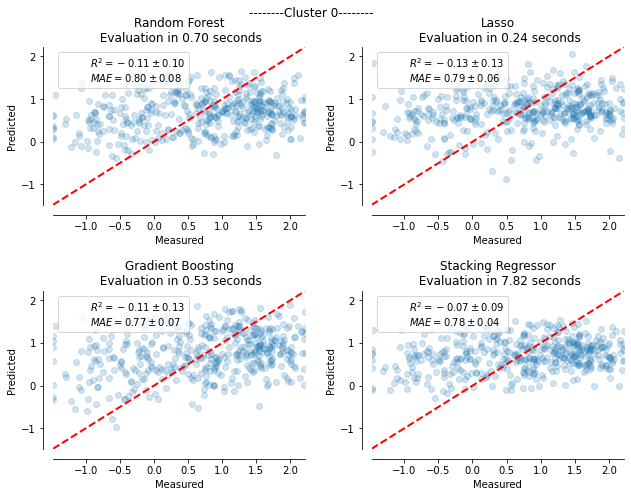

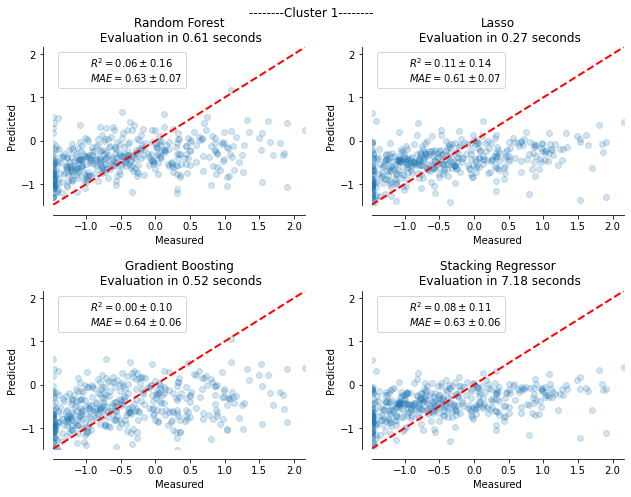

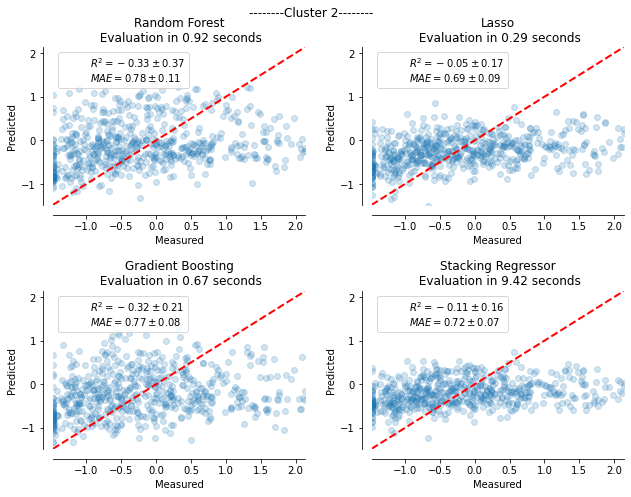

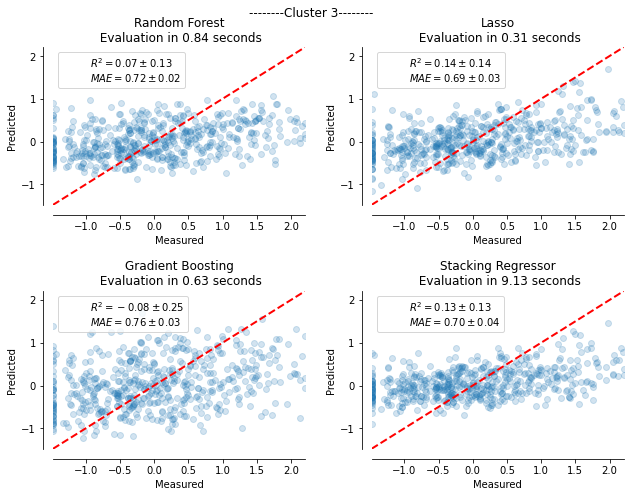

In [430]:
n_cluster = 4

for i in range(n_cluster):

    cluster_no = i

    cluster_subset_df = scaled_classified_df[scaled_classified_df['class']==cluster_no]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        y = cluster_subset_df['crimes']
        X = cluster_subset_df.drop('crimes', axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        axs = np.ravel(axs)

        for ax, (name, est) in zip(
            axs, estimators + [("Stacking Regressor", stacking_regressor)]
        ):
            start_time = time.time()
            score = cross_validate(
                est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
            )
            elapsed_time = time.time() - start_time

            y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

            plot_regression_results(
                ax,
                y,
                y_pred,
                name,
                (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                    np.mean(score["test_r2"]),
                    np.std(score["test_r2"]),
                    -np.mean(score["test_neg_mean_absolute_error"]),
                    np.std(score["test_neg_mean_absolute_error"]),
                ),
                elapsed_time,
            )

        plt.suptitle(f"--------Cluster {i}--------")
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()